In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import time

In [28]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

/var/folders/85/j2qtn7190hzcnyrjdrk1grc80000gn/T/ipykernel_1623/152022097.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [29]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

In [30]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [31]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11,16)
        self.hl1 = nn.Linear(16,32)
        self.hl2 = nn.Linear(32,32)
        self.output = nn.Linear(32,1)

    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.hl1(x))
        x = F.relu(self.hl2(x))
        return self.output(x)

In [32]:
numEpochs = 1000

def trainTheModel():
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(wineANN.parameters(), lr=.01)

    losses = torch.zeros(numEpochs)

    trainAcc = []
    testAcc = []

    for epochi in range(numEpochs):
        wineANN.train()

        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            yHat = wineANN(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        wineANN.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = wineANN(X)

        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

    return trainAcc, testAcc, losses

In [33]:
batchSizes = 2**np.arange(1,10,2)

accuracyResultTrain = np.zeros((numEpochs, len(batchSizes)))
accuracyResultTest = np.zeros((numEpochs, len(batchSizes)))
comptime = np.zeros(len(batchSizes))

test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

for bi in range(len(batchSizes)):
    starttime = time.process_time()

    train_loader = DataLoader(train_data, batch_size=int(batchSizes[bi]), shuffle=True, drop_last=True)

    wineANN = ANNwine()

    trainAcc, testAcc, losses = trainTheModel()

    accuracyResultTrain[:, bi] = trainAcc
    accuracyResultTest[:, bi] = testAcc

    comptime[bi] = time.process_time() - starttime

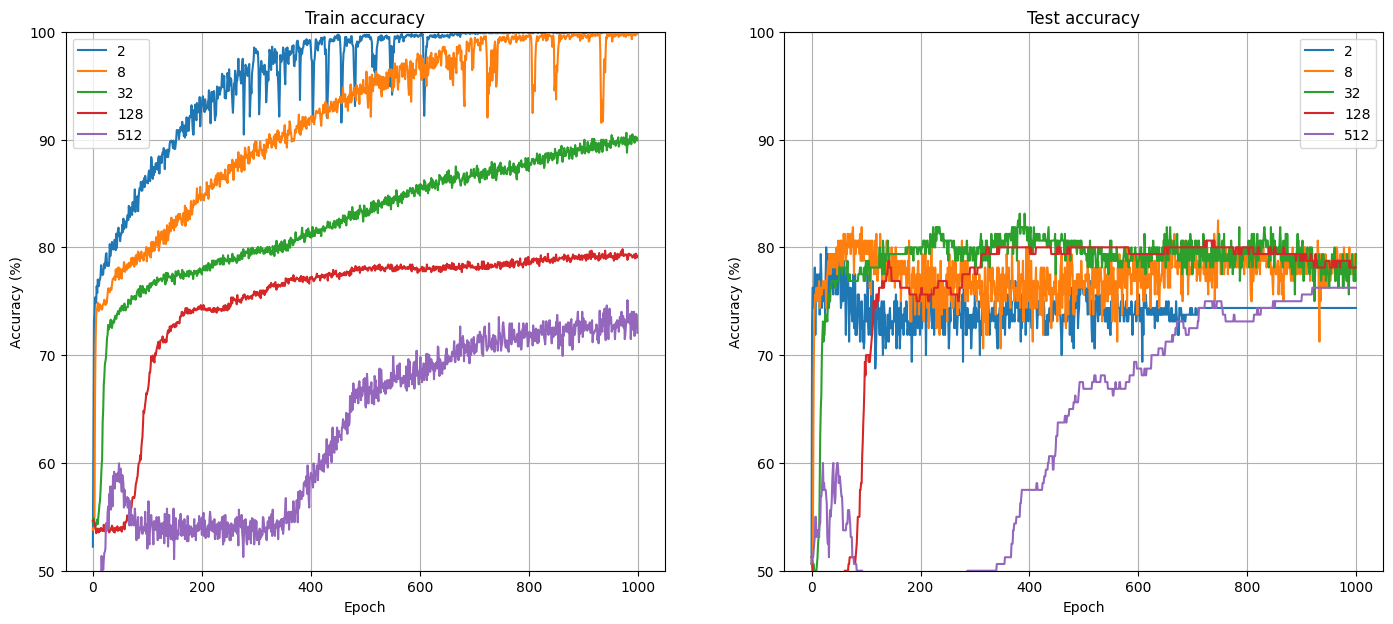

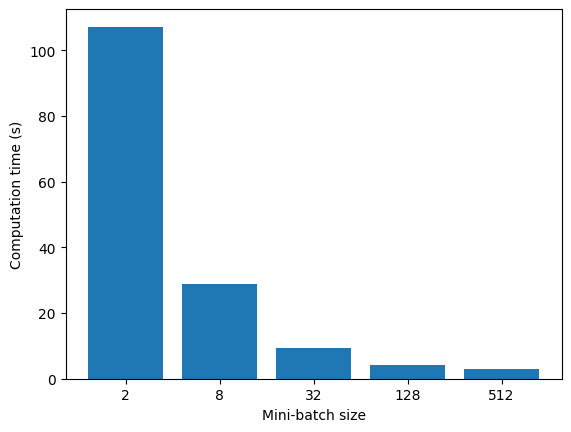

In [36]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultTest)
ax[1].set_title('Test accuracy')

for i in range(2):
    ax[i].legend(batchSizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,100])
    ax[i].grid()

plt.show()

plt.bar(range(len(comptime)),comptime,tick_label=batchSizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()